## Imports

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from copy import deepcopy

In [6]:
# Pretty plots
import seaborn as sns
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rc('font',family='serif', serif=['Palatino'])
sns.set(font='serif', font_scale=1.4)
sns.set_style("white", {
        "font.family": "serif",
        "font.weight": "normal",
        "font.serif": ["Times", "Palatino", "serif"],
        'axes.facecolor': 'white',
        'lines.markeredgewidth': 1})

def setup_plot():
    fig = plt.figure(dpi=100, figsize=(5.0,3.0))
    ax = plt.subplot(111)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 15)
    ax.tick_params(direction='in')

In [54]:
from src.models import Model, LinearModel
from src.oadam import OAdam, add_weight_decay, net_to_list

## Algorithms

In [42]:
def BC(D_E, loss_fn, pi_0, lr=3e-4, steps=int(1e5)):
    pi = pi_0
    X = np.concatenate([x[0] for x in D_E], axis=0)
    U = np.concatenate([x[1] for x in D_E], axis=0)
    print('BC Data', X.shape, U.shape)
    optimizer = optim.Adam(pi.parameters(), lr=lr)
    for step in range(steps):
        idx = np.random.choice(len(X), 32)
        states = torch.from_numpy(X[idx])
        actions = torch.from_numpy(U[idx])

        optimizer.zero_grad()

        outputs = pi(states.float())
        loss = loss_fn(outputs, actions.float())
        loss.backward()
        optimizer.step()
#         if step % 1000 == 0:
#             print(step,
#                   mse2(lambda s: pi(torch.from_numpy(s).float()).detach().numpy()),
#                   mse(lambda s: pi(torch.from_numpy(s).float()).detach().numpy()))
        
    return pi

In [43]:
def DoubIL(D_E, pi_0, dynamics, lr=3e-4, nsamp=10, pi_BC=None):
    loss_fn = nn.MSELoss()
    pi_init = deepcopy(pi_0)
    if pi_BC is None:
        pi_BC = BC(D_E, nn.MSELoss(), pi_0, lr=lr)
    print("Done w/ BC")
    X_trajs = [x[0] for x in D_E]
    U_trajs = [x[1] for x in D_E]
    X_IV = []
    for _ in range(nsamp):
        U_BC = [pi_BC(torch.from_numpy(xt[:-1]).float()).detach().numpy() + 1 * np.random.normal(size=(len(xt[:-1]), 1)) +  2 * np.random.normal(size=(len(xt[:-1]), 1)) for xt in X_trajs]
        X_prime = np.concatenate([dynamics(X_trajs[i][:-1], U_BC[i]) for i in range(len(D_E))], axis=0)
        X_IV.append(X_prime)
    U_IV = np.concatenate([ut[1:] for ut in U_trajs], axis=0)
    print('IV Data', X_IV[0].shape, U_IV.shape)
    pi = pi_init
    optimizer = optim.Adam(pi.parameters(), lr=lr)
    for step in range(int(5e4)):
        idx = np.random.choice(len(X_IV[0]), 128)
        actions = torch.from_numpy(U_IV[idx])
        optimizer.zero_grad()
        outputs_1 = 0
        outputs_2 = 0
        sample_idx = list(range(nsamp))
        np.random.shuffle(sample_idx)
        for i in range(int(nsamp / 2)):
            states_1 = torch.from_numpy(X_IV[sample_idx[i]][idx])
            states_2 = torch.from_numpy(X_IV[sample_idx[i + int(nsamp / 2)]][idx])
            with torch.no_grad():
                outputs_1 += pi(states_1.float())
            outputs_2 += pi(states_2.float())
        outputs_1 = outputs_1 / (nsamp / 2)
        outputs_2 = outputs_2 / (nsamp / 2)
        factor_1 = (outputs_1 - actions.float()).detach()
        factor_2 = outputs_2 - actions.float()
        loss_1 = torch.mean(factor_1 * factor_2)
        loss_2 = loss_fn((outputs_1 + outputs_2) / 2, actions.float())
        loss = loss_1 + 0.05 * loss_2
        loss.backward()
        optimizer.step()
#         if step % 1000 == 0:
#             print(step,
#                   mse2(lambda s: pi(torch.from_numpy(s).float()).detach().numpy()),
#                   mse(lambda s: pi(torch.from_numpy(s).float()).detach().numpy()))
    return pi

In [61]:
def ResiduIL(D_E, pi_0, f_0, lr=1e-3, f_norm_penalty=0, bc_reg=0):
    pi = pi_0
    f = f_0
    
#     optimizer_pi = OAdam(add_weight_decay(pi, 1e-3),
#                                     lr=lr, betas=(0, .01))
#     optimizer_f = OAdam(add_weight_decay(f, 1e-3),
#                                     lr=lr, betas=(0, .01))
    
    optimizer_pi = OAdam(net_to_list(pi),
                                    lr=lr, betas=(0, .01))
    optimizer_f = OAdam(net_to_list(f),
                                    lr=lr, betas=(0, .01))


    X_trajs = [x[0] for x in D_E]
    U_trajs = [x[1] for x in D_E]
    
    X = np.concatenate([xt[1:] for xt in X_trajs], axis=0)
    U = np.concatenate([ut[1:] for ut in U_trajs], axis=0)
    X_past = np.concatenate([xt[:-1] for xt in X_trajs], axis=0)
    last_MSE = 1e6
    
    for step in range(int(5e4)):
        idx = np.random.choice(len(X), 128)
        pi_inputs = torch.from_numpy(X[idx])
        f_inputs = torch.from_numpy(X_past[idx])
        targets = torch.from_numpy(U[idx]).float()

        optimizer_pi.zero_grad()
        preds = pi(pi_inputs.float())
        pred_residuals = f(f_inputs.float())
        loss = torch.mean(2 * (targets - preds) * pred_residuals)
        loss = loss + bc_reg * torch.mean(torch.square(targets - preds))
        loss.backward()
        optimizer_pi.step()
    
        optimizer_f.zero_grad()
        preds = pi(pi_inputs.float())
        pred_residuals = f(f_inputs.float())
        loss = -torch.mean(2 * (targets - preds) * pred_residuals - pred_residuals * pred_residuals)
        loss = loss + f_norm_penalty * torch.linalg.norm(pred_residuals)
        loss.backward()
        optimizer_f.step()
        
#         if step % 1000 == 0:
#             K_ResiduIL = [x.detach().numpy() for x in pi.parameters()][0].reshape(-1)
#             print('Param. MSE =', np.linalg.norm(K_star - K_ResiduIL))
            
#             print(step,
#                   mse2(lambda s: pi(torch.from_numpy(s).float()).detach().numpy()),
#                   mse(lambda s: pi(torch.from_numpy(s).float()).detach().numpy()))
        
#         if step % 100 == 0 and step > 20000: # Early Stopping
#             MSE = torch.mean(torch.square(torch.from_numpy(U).float() - pi(torch.from_numpy(X).float())))
#             if MSE > last_MSE:
#                 print(step)
#                 return pi
#             else:
#                 last_MSE = MSE
    return pi

In [18]:
def DAgger(D_E, pi_0, lr=3e-4, nsamp=20, pi_BC = None):
    D = []
    if pi_BC is None:
        pi = BC(D_E, nn.MSELoss(), pi_0, lr=lr)
    else:
        pi = pi_BC
    for rnd in range(10):
        D_new = []
        for _ in range(nsamp):
            s_0 = np.random.normal(size=(2, 1))
            s_traj, a_traj, _ = noisy_rollout(s_0, lambda s: pi(torch.from_numpy(s.reshape(1, -1)).float()).detach().numpy())
            a_E_traj = expert(s_traj)
            D_new.append((s_traj, a_E_traj))
        D.extend(D_new)
        pi = BC(D, nn.MSELoss(), pi, lr=lr, steps=5000)
#         print('DAgger', rnd * 5000,
#               mse2(lambda s: pi(torch.from_numpy(s).float()).detach().numpy()),
#               mse(lambda s: pi(torch.from_numpy(s).float()).detach().numpy()))
    return pi

## LQG System

In [36]:
import src.lqg

In [37]:
K_star = src.lqg.solve(src.lqg.A, src.lqg.B, src.lqg.Q, src.lqg.R)
print(K_star)
def expert(s):
    if s.size == 2:
        return K_star @ s
    else:
        return s @ K_star.T

Converged with horizon 34
[[-2.57543063 -3.43994714]]


In [38]:
denoised_expert_trajs = []
for _ in range(100):
    s_0 = np.random.normal(size=(2, 1))
    s_traj, a_traj, _ = src.lqg.rollout(s_0, expert)
    denoised_expert_trajs.append((s_traj, a_traj))

Text(0, 0.5, 'pos.')

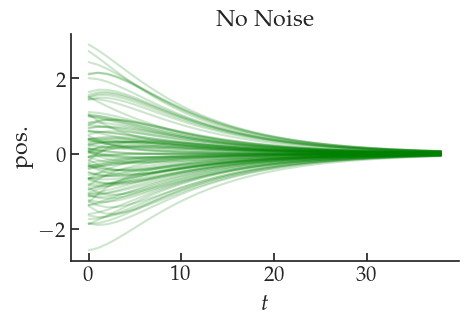

In [39]:
setup_plot()
for (pos, vel) in denoised_expert_trajs:
    plt.plot(np.arange(len(pos)), pos[:, 0], color="green", alpha=0.2)
plt.title("No Noise")
plt.xlabel("$t$")
plt.ylabel("pos.")

In [40]:
expert_trajs = []
for _ in range(100):
    s_0 = np.random.normal(size=(2, 1))
    s_traj, a_traj, _ = src.lqg.noisy_rollout(s_0, expert)
    expert_trajs.append((s_traj, a_traj))

Text(0, 0.5, 'pos.')

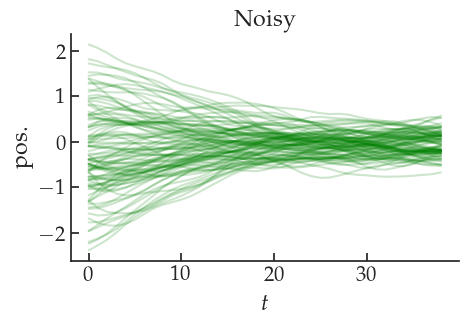

In [41]:
setup_plot()
for (pos, vel) in expert_trajs:
    plt.plot(np.arange(len(pos)), pos[:, 0], color="green", alpha=0.2)
plt.title("Noisy")
plt.xlabel("$t$")
plt.ylabel("pos.")

In [46]:
pi_BC = BC(expert_trajs, nn.MSELoss(), LinearModel(2, 1), lr=3e-4, steps=int(5e4))
K_BC = [x.detach().numpy() for x in pi_BC.parameters()][0].reshape(-1)
print('Param. MSE =', np.linalg.norm(K_star - K_BC))

BC Data (3900, 2) (3900, 1)
Param. MSE = 1.2316205609388096


In [49]:
pi_DoubIL = DoubIL(expert_trajs, LinearModel(2, 1), dynamics, pi_BC=pi_BC, lr=3e-4)
K_DoubIL = [x.detach().numpy() for x in pi_DoubIL.parameters()][0].reshape(-1)
print('Param. MSE =', np.linalg.norm(K_star - K_DoubIL))

Done w/ BC
IV Data (3800, 2) (3800, 1)
Param. MSE = 0.2359039074168715


In [62]:
pi_ResiduIL = ResiduIL(expert_trajs, LinearModel(2, 1), LinearModel(2, 1), lr=3e-4)
K_ResiduIL = [x.detach().numpy() for x in pi_ResiduIL.parameters()][0].reshape(-1)
print('Param. MSE =', np.linalg.norm(K_star - K_ResiduIL))

Param. MSE = 0.12843516488121823


## LunarLander

In [1]:
from src.lunar_lander_env import LunarLanderContinuous

In [2]:
env = LunarLanderContinuous()

In [3]:
import gym
from stable_baselines3 import PPO

In [ ]:
model = PPO('MlpPolicy', env, verbose=1,
                policy_kwargs=dict(net_arch=[64, 64]))
model.learn(total_timesteps=2e6)
model.save("./lunarlander_expert") # need to re-train w/ noise

Using cpu device
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 1710 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 1174       |
|    iterations           | 2          |
|    time_elapsed         | 3          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00925414 |
|    clip_fraction        | 0.0365     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.85      |
|    explained_variance   | -4.89e+04  |
|    learning_rate        | 0.0003     |
|    loss                 | 885        |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.00681   |
|    std                  | 1.01       |
|    value_loss           | 2.02e+03   |


------------------------------------------
| time/                   |              |
|    fps                  | 896          |
|    iterations           | 12           |
|    time_elapsed         | 27           |
|    total_timesteps      | 24576        |
| train/                  |              |
|    approx_kl            | 0.0053424165 |
|    clip_fraction        | 0.141        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.79        |
|    explained_variance   | -2.08e+07    |
|    learning_rate        | 0.0003       |
|    loss                 | 171          |
|    n_updates            | 110          |
|    policy_gradient_loss | -0.00125     |
|    std                  | 0.975        |
|    value_loss           | 738          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 890          |
|    iterations           | 13           |
|    time_e

-----------------------------------------
| time/                   |             |
|    fps                  | 816         |
|    iterations           | 23          |
|    time_elapsed         | 57          |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.005566674 |
|    clip_fraction        | 0.0269      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.78       |
|    explained_variance   | -18.3       |
|    learning_rate        | 0.0003      |
|    loss                 | 447         |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.00247    |
|    std                  | 0.976       |
|    value_loss           | 859         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 809         |
|    iterations           | 24          |
|    time_elapsed         | 60    

-----------------------------------------
| time/                   |             |
|    fps                  | 829         |
|    iterations           | 34          |
|    time_elapsed         | 83          |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.005970925 |
|    clip_fraction        | 0.0633      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.74       |
|    explained_variance   | -1.21       |
|    learning_rate        | 0.0003      |
|    loss                 | 463         |
|    n_updates            | 330         |
|    policy_gradient_loss | 1.47e-05    |
|    std                  | 0.953       |
|    value_loss           | 763         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 829        |
|    iterations           | 35         |
|    time_elapsed         | 86        